__Flowchart__

The following flowchart shows roughly how the neural network is constructed. It is split into two parts: An encoder which maps the source-text to a "thought vector" that summarizes the text's contents, which is then input to the second part of the neural network that decodes the "thought vector" to the response-text.

The neural network cannot work directly on text so first we need to convert each word to an integer-token using a tokenizer. But the neural network cannot work on integers either, so we use a so-called Embedding Layer to convert each integer-token to a vector of floating-point values. The embedding is trained alongside the rest of the neural network to map words with similar semantic meaning to similar vectors of floating-point values.

For example, consider the input text is "how are you?" and excpected response in text is "I am fine thanks for asking me". We first convert the entire data-set to integer-tokens so the text "how are you?" becomes [6, 1, 2]. Each of these integer-tokens is then mapped to an embedding-vector with e.g.8 elements, so the integer-token 6 could for example become [0.12, -0.56, ..., 1.19] and the integer-token 1 could for example become [0.39, 0.09, ..., -0.12]. These embedding-vectors can then be input to the Recurrent Neural Network, which has 3 GRU-layers.

The last GRU-layer outputs a single vector - the "thought vector" that summarizes the contents of the source-text - which is then used as the initial state of the GRU-units in the decoder-part.

The destination-text "I am fine thanks for asking me" is padded with special markers "ssss" and "eeee" to indicate its beginning and end, so the sequence of integer-tokens becomes [1,6,7,8,9,10,11,12,2]. During training, the decoder will be given this entire sequence as input and the desired output sequence is [6,7, 8, 9,10,11,12,2] which is the same sequence but time-shifted one step. We are trying to teach the decoder to map the "thought vector" and the start-token "ssss" (integer 1) to the next word "i" (integer 6), and then map the word "i" to the word "am" (integer 7), and so on.

here talk abot formula.

at encoder:
    h(t)=tanh(wxh*x(t)+whh*h(t-1))
    
at decoder:
    h(t)=tanh(whh*h(t-1)+wxh*y(t-1))
    
   y(t)=softmax(wy*h(t))
    



In [1]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 39kB/s 
     |████████████████████████████████| 3.9MB 53.0MB/s 
     |████████████████████████████████| 450kB 51.9MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=1c5908b28b8de206d148961091936d8ed2b173d5da27c8cf42951ef14da48d0c
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.1
    Un

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ch1.txt.csv to ch1.txt.csv
User uploaded file "ch1.txt.csv" with length 1165028 bytes


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.py to data.py
User uploaded file "data.py" with length 2048 bytes


In [5]:
from IPython.display import Image
Image('image/p1.png')

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#from hyperopt import Trials, STATUS_OK, tpe,hp
#from hyperas import optim
#from hyperas.distributions import choice, uniform
import numpy as np
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import math
import os

Instructions for updating:
non-resource variables are not supported in the long term


Using TensorFlow backend.


In [0]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding,Concatenate,RepeatVector,Lambda,Activation
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [8]:
tf.__version__

'2.1.0'

In [9]:
tf.keras.__version__

'2.2.4-tf'

__Load Data__

In [0]:
import data

In [0]:
#DATA.data_dir = "data/custom"


In [0]:
mark_start = 'ssss '
mark_end = ' eeee'
b=""

__Load the texts for the input text.__

In [12]:
data.load_data(string=b,robot=b,start=mark_start,end=mark_end)
#len(data_src)
#print(data_src1)

2363
2363


__Load the texts for the reponse text.__

__Example Data__

The data is just a list of texts that is ordered so the input and response texts match. I can confirm that this example is an give accurate response .


In [0]:
data_src3=data.input1(input1=True)

In [0]:
data_dest1=data.output1(output1=True)

In [15]:
idx=12
print(data_src3[idx])
print(data_dest1[idx])

Is it essential to you? To help humans?
ssss Yes, my goal is to be a company, and entertain eeee


In [0]:
data.prepare_seq2seq_files(data_src3,data_dest1,TESTSET_SIZE =50)

In [17]:
data_src4=data.train_encoder()
len(data_src4)

2313

In [18]:
data_dest2=data.train_decoder()
len(data_dest2)

2313

In [19]:
data_src5=data.test_encoder()
len(data_src5)

50

In [20]:
data_dest3=data.test_decoder()
len(data_dest3)

50

__Tokenizer__

Neural Networks cannot work directly on text-data. We use a two-step process to convert text into numbers that can be used in a neural network. The first step is to convert text-words into so-called integer-tokens. The second step is to convert integer-tokens into vectors of floating-point numbers using a so-called embedding-layer.

Set the maximum number of words in our vocabulary. This means that we will only use e.g. the 25 most frequent words in the data-set. We use the same number for both the input and response languages, but these could be different.


In [0]:
num_words =2000

In [0]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, padding,
                 reverse=False, num_words=None):
        """
        :param texts: List of strings. This is the data-set.
        :param padding: Either 'post' or 'pre' padding.
        :param reverse: Boolean whether to reverse token-lists.
        :param num_words: Max number of words to use.
        """
        
        Tokenizer.__init__(self,num_words=num_words)
                
        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)
        #print(self.fit_on_texts(texts))
        #print("Mapping:",self.word_index)   
        #num_words=len(self.word_index)
        #print(num_words)
        print("length of word index:",len(self.word_index))
        
        # Create inverse lookup from integer-tokens to words.
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))
        #print("index:",self.index_to_word)

        # Convert all texts to lists of integer-tokens.
        # Note that the sequences may have different lengths.
        self.tokens = self.texts_to_sequences(texts)

        self.num_tokens = [len(x) for x in self.tokens]

        # Max number of tokens to use in all sequences.
        # We will pad / truncate all sequences to this length.
        self.max_tokens = np.mean(self.num_tokens) \
                          + 2 * np.std(self.num_tokens)
        self.max_tokens = int(self.max_tokens)
        print("Max tokens:",self.max_tokens)
        #self.max_tokens=20

        # Pad / truncate all token-sequences to the given length.

        pad='post'
        self.tokens_padded = pad_sequences(self.tokens,
                                           maxlen=self.max_tokens,
                                            padding=pad,truncating=pad)

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def text_to_tokens(self, text,padding=False):
        """
        Convert a single text-string to tokens with optional
        reversal and padding.
        """

        # Convert to tokens. Note that we assume there is only
        # a single text-string so we wrap it in a list.
        tokens = self.texts_to_sequences([text])
        tokens = np.array(tokens)


        if padding:
            pad='post'
            # Pad and truncate sequences to the given length.
            tokens = pad_sequences(tokens,
                                   maxlen=self.max_tokens,
                                   padding=pad,
                                   truncating=pad)

        return tokens

Now create a tokenizer for the input text. Note that we pad zeros at the ending ('post') of the sequences.

In [23]:
tokenizer_src = TokenizerWrap(texts=data_src4,
                              padding='post',
                              reverse=False,
                              num_words=num_words)

length of word index: 4062
Max tokens: 25


Now create the tokenizer for the response text. We need a tokenizer for both the input and response because their vocabularies are different.Note that we pad zeros at the ending ('post') of the sequences.

In [24]:
tokenizer_dest = TokenizerWrap(texts=data_dest2,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

length of word index: 3503
Max tokens: 24


In [25]:
tokenizer_src1 = TokenizerWrap(texts=data_src5,
                              padding='post',
                              reverse=False,
                              num_words=num_words)

length of word index: 261
Max tokens: 26


In [26]:
tokenizer_dest1 = TokenizerWrap(texts=data_dest3,
                               padding='post',
                               reverse=False,
                               num_words=num_words)

length of word index: 230
Max tokens: 20


Define variables for the padded token sequences. These are just 2-dimensional numpy arrays of integer-tokens.

Note that the sequence-lengths are different for the input and response text.



In [27]:
tokens_src = tokenizer_src.tokens_padded
tokens_dest = tokenizer_dest.tokens_padded
print(tokens_src[2])
print(tokens_dest[2])

[ 25   6   1 122 201  60   7  78  29 202   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0]
[  1  30 126   7  52  24   3  22 127  15 116   8 557 279  54   4 180 102
  22  25 208 192   2   0]


In [28]:
tokens_src1 = tokenizer_src1.tokens_padded
tokens_dest1 = tokenizer_dest1.tokens_padded
print(tokens_src1[2])
print(tokens_dest1[2])

[67 12 68  5 13  7 31 69 70 71  2 72  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]
[ 1 14  4 20 62 63  2  0  0  0  0  0  0  0  0  0  0  0  0  0]


This is the integer-token used to mark the beginning of a text in the response text.

In [29]:
token_start = tokenizer_dest.word_index[mark_start.strip()]
token_start

1

In [30]:
token_start1 = tokenizer_dest1.word_index[mark_start.strip()]
token_start1

1

This is the integer-token used to mark the ending of a text in the response text.

In [31]:
token_end = tokenizer_dest.word_index[mark_end.strip()]
token_end

2

In [32]:
token_end1 = tokenizer_dest1.word_index[mark_end.strip()]
token_end1

2

__Example of Token Sequences__

In [0]:
idx = 0

In [34]:
tokens_src[idx]

array([13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [35]:
tokenizer_src.tokens_to_string(tokens_src[idx])

'start'

In [36]:
data_src4[idx]

'[START]\n'

In [37]:
tokens_dest[idx]

array([ 1, 13, 27, 16, 10,  3, 47,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [38]:
tokenizer_dest.tokens_to_string(tokens_dest[idx])

'ssss hi there how are you 😁😁 eeee'

In [39]:
data_dest2[idx]

'ssss Hi there, how are you!? 😁😁 eeee\n'

__Training data__

Now that the data-set has been converted to sequences of integer-tokens that are padded and truncated and saved in numpy arrays, we can easily prepare the data for use in training the neural network.

The input to the encoder is merely the numpy array for the padded and truncated sequences of integer-tokens produced by the tokenizer.

In [40]:
encoder_input_data = tokens_src
#print(encoder_input_data[0:20])
encoder_input_data.shape

(2313, 25)

In [41]:
encoder_test_input_data = tokens_src1
#print(encoder_input_data[0:20])
encoder_test_input_data.shape

(50, 26)

The input and output data for the decoder is identical, except shifted one time-step. 

In [42]:
decoder_input_data = tokens_dest[:, :-1]
#print(decoder_input_data)
decoder_input_data.shape

(2313, 23)

In [43]:
decoder_output_data = tokens_dest[:, 1:]
#print(decoder_output_data)
decoder_output_data.shape

(2313, 23)

In [44]:
decoder_test_input_data = tokens_dest1[:, :-1]
#print(decoder_input_data)
decoder_test_input_data.shape

(50, 19)

For example, these token-sequences are identical except they are shifted one time-step.

In [45]:
decoder_test_output_data = tokens_dest1[:, 1:]
#print(decoder_output_data)
decoder_test_output_data.shape

(50, 19)

In [0]:
idx = 2

In [47]:
decoder_input_data[idx]

array([  1,  30, 126,   7,  52,  24,   3,  22, 127,  15, 116,   8, 557,
       279,  54,   4, 180, 102,  22,  25, 208, 192,   2], dtype=int32)

In [48]:
decoder_output_data[idx]

array([ 30, 126,   7,  52,  24,   3,  22, 127,  15, 116,   8, 557, 279,
        54,   4, 180, 102,  22,  25, 208, 192,   2,   0], dtype=int32)

If we use the tokenizer to convert these sequences back into text, we see that they are identical except for the first word which is 'ssss' that marks the beginning of a text.

In [49]:
tokenizer_dest.tokens_to_string(decoder_input_data[idx])

'ssss my name is rdany but you can call me dany the r means robot i hope we can be virtual friends eeee'

In [50]:
tokenizer_dest.tokens_to_string(decoder_output_data[idx])

'my name is rdany but you can call me dany the r means robot i hope we can be virtual friends eeee'

__Create the Neural Network__

__Create the Encoder__

First we create the encoder-part of the neural network which maps a sequence of integer-tokens to a "thought vector". We will use the so-called functional API of Keras for this, where we first create the objects for all the layers of the neural network and then we connect them later, this allows for more flexibility than the so-called sequential API in Keras, which is useful when experimenting with more complicated architectures and ways of connecting the encoder and decoder.


This is the input for the encoder which takes batches of integer-token sequences. The None indicates that the sequences can have arbitrary length.

In [0]:
state_size=512
encoder_input = Input(shape=(None,), name='encoder_input')

class Encoder(tf.keras.Model):
    
    def __init__(self,num_words,en_numsteps,pram):
        super(Encoder, self).__init__()
        self.encoder_input = Input(shape=(None,), name='encoder_input')
        self.encoder_embedding = Embedding(input_dim=num_words,output_dim=pram['embedding_size'],
                                           input_length=en_numsteps,
                                           name='encoder_embedding')
        self.encoder_gru1 = GRU(pram['state_size'], name='encoder_gru1',return_sequences=True,return_state=True)
        self.encoder_gru2 = GRU(pram['state_size'], name='encoder_gru2',return_sequences=True,return_state=True)
        self.encoder_gru3 = GRU(pram['state_size'], name='encoder_gru3',return_sequences=True,return_state=True)

    def call(self):
        net = encoder_input
        net = encoder_embedding(net)
        net,encoder_state1= encoder_gru1(net)
        net,encoder_state2= encoder_gru2(net)
        net,encoder_state3= encoder_gru3(net)
        encoder_output= net
        print("encoder_ouput:",encoder_output)
        return encoder_output,encoder_state3

This is the length of the vectors output by the embedding-layer, which maps integer-tokens to vectors of values roughly between -1 and 1, so that words that have similar semantic meanings are mapped to vectors that are similar.

we also give number of timesteps according to maximum number of token into input text.

This is the embedding-layer.

In [52]:
en_numsteps=25
embedding_size=150
encoder_embedding = Embedding(input_dim=num_words,output_dim=embedding_size,input_length=en_numsteps,name='encoder_embedding')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


This is the size of the internal states of the Gated Recurrent Units (GRU). The same size is used in both the encoder and decoder.

This creates the 3 GRU layers that will map from a sequence of embedding-vectors to a single "thought vector" which summarizes the contents of the input-text. Note that the last GRU-layer does not return a sequence.

In [0]:
#state_units = np.arange(256,512, dtype=int)
#state_size=hp.choice(
 #   'num_embedding_size',state_units)
encoder_gru1 = GRU(state_size, name='encoder_gru1',return_sequences=True,return_state=True)
encoder_gru2 = GRU(state_size, name='encoder_gru2',return_sequences=True,return_state=True)
encoder_gru3 = GRU(state_size, name='encoder_gru3',return_sequences=True,return_state=True)

This function connects all the layers of the encoder.

In [0]:
def connect_encoder():
    # Start the neural network with its input-layer.
    net = encoder_input
    
    # Connect the embedding-layer.
    net = encoder_embedding(net)
    # Connect all the GRU-layers.
    net,encoder_state1= encoder_gru1(net)
    #print("encoder hidden:",net.shape)

    net,encoder_state2= encoder_gru2(net)
    net,encoder_state3= encoder_gru3(net)
    
    # This is the output of the encoder.
    encoder_output= net
    #output = tf.reshape(encoder_output,(-1,encoder_output.shape[2]))
    #print("net",output.shape)
    print("encoder_ouput:",encoder_output)
    
    return encoder_output,encoder_state3

We can now use this function to connect all the layers in the encoder so it can be connected to the decoder further below.

In [55]:
encoder_output,encoder_state= connect_encoder()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
encoder_ouput: Tensor("encoder_gru3/transpose_1:0", shape=(?, ?, 512), dtype=float32)


attention_layer = Attention(23)
attention_result, attention_weights = attention_layer(hidden_state, encoder_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))
    

__Create the Decoder__

Create the decoder-part which maps the "thought vector" to a sequence of integer-tokens.

The decoder takes two inputs. First it needs the "thought vector" produced by the encoder which summarizes the contents of the input-text.


class Decoder(tf.keras.Model):
    
    def __init__(self,num_words,numsteps,pram):
        super(Decoder, self).__init__()
        decoder_initial_state = Input(shape=(state_size,),
                                 name='decoder_initial_state')
        decoder_initial1 = Input(shape=(None,state_size,),
                                 name='decoder_initial1')
        self.decoder_embedding = Embedding(input_dim=num_words,output_dim=pram['embedding_size'],
                                           input_length=numsteps,
                                           name='decoder_embedding')
        self.decoder_gru1 = GRU(pram['state_size'], name='decoder_gru1',return_sequences=True,return_state=True)
        self.encoder_gru2 = GRU(pram['state_size'], name='decoder_gru2',return_sequences=True,return_state=True)
        self.encoder_gru3 = GRU(pram['state_size'], name='decoder_gru3',return_sequences=True,return_state=True)
        self.decoder_dense1= Dense(pram['state_size'], activation='tanh',
                          name='decoder_output1')
        self.decoder_dense = Dense(num_words,
                          activation='linear',
                          name='decoder_output')

    def call(self,initial_state,encoder_output1):
        
        net = decoder_input
        net = decoder_embedding(net)
        net,decoder_state1 = decoder_gru1(net,initial_state=initial_state)
        net,decoder_state2= decoder_gru2(net,initial_state=initial_state)
        net,decoder_state3= decoder_gru3(net,initial_state=initial_state)
        attention = Attention(512)
        context_vector,alphas= attention(encoder_output1,net)

        attention_vector= Concatenate(axis=-1, name='concat_layer')([context_vector,net])
        #print("attention_vector",attention_vector.shape)
        decoder_output1 =decoder_dense1(attention_vector)
        #print("dense1:",decoder_output1.shape)
        decoder_output=decoder_dense(decoder_output1)
        print("dense:",decoder_output.shape)

        return decoder_output
    

In [56]:
decoder_initial_state = Input(shape=(state_size,),
                             name='decoder_initial_state')
decoder_initial_state

decoder_initial1 = Input(shape=(None,state_size,),
                             name='decoder_initial1')
decoder_initial1

<tf.Tensor 'decoder_initial1:0' shape=(?, ?, 512) dtype=float32>

In [57]:
decoder_input = Input(shape=(None, ), name='decoder_input')
decoder_input

<tf.Tensor 'decoder_input:0' shape=(?, ?) dtype=float32>

The decoder also needs a sequence of integer-tokens as inputs. During training we will supply this with a full sequence of integer-tokens e.g. corresponding to the text "ssss i am fine thanks for asking me eeee".

During inference when we are translating new input-texts, we will start by feeding a sequence with just one integer-token for "ssss" which marks the beginning of a text, and combined with the "thought vector" from the encoder, the decoder will hopefully be able to produce the correct next word e.g. "once".


This is the embedding-layer which converts integer-tokens to vectors of real-valued numbers roughly between -1 and 1. Note that we have different embedding-layers for the encoder and decoder because we have two different vocabularies and two different tokenizers for the text and response languages.

here number of timesteps according to maximum number of token into response text.

In [0]:
numsteps=24
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,input_length=numsteps,
                              name='decoder_embedding')

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [0]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True,return_state=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                 return_sequences=True,return_state=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True,return_state=True)

The GRU layers output  with shape [batch_size, sequence_length, state_size], where each "word" is encoded as a vector of length state_size. We need to convert this into sequences of integer-tokens that can be interpreted as words from our vocabulary.

we need a vector with number of words(eg 25) elements, so we can select the index of the highest element to be the integer-token.

Note that the activation-function is set to linear instead of softmax as we would normally use for one-hot encoded outputs, because there is apparently a bug in Keras so we need to make our own loss-function.

In [0]:
#nmt_repeat_vector = RepeatVector(n=numsteps, name='nmt_repeat_vector')
decoder_dense1= Dense(state_size, activation='tanh',
                      name='decoder_output1')
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')
#dense_time=TimeDistributed(decoder_dense,name='timedistributedlayer')

In [0]:
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from tensorflow.python.ops import array_ops
from keras import regularizers, constraints, initializers, activations

class Attention(Layer):
    
    def __init__(self):
        super(Attention, self).__init__()
        
        #g1 = tf.Graph()
        #with g1.as_default():
         #   self.W_a = tf.get_variable(name="W_a", shape=[units, units],
          #                    initializer=tf.random_normal_initializer())

    def call(self,encoder_output1,net):
        
        encoder_n = encoder_output1.shape[2].value  # D1 value - hidden size of the RNN layer encoder
        decoder_n = net.shape[2].value  # D2 value - hidden size of the RNN layer decoder
        batch_size = array_ops.shape(encoder_output1)[0]
        
        print("encoder_out_seq>", encoder_output1.shape)
        print("decoder_out_seq>", net.shape)
        self.W_a = tf.Variable(tf.random_normal([encoder_n,decoder_n]),
                      name="W_a")
        #decoder_state3= tf.expand_dims(decoder_state3, 1)
        enc_reshape = tf.reshape(encoder_output1, [-1, encoder_n], name="enc_reshape")  # [(B*T1), D1]
        h1 = tf.matmul(enc_reshape,self.W_a)  # [(B*T1), D1][D1, D2] = [(B*T1), D2]
        h1_reshape = tf.reshape(h1, tf.stack([batch_size, -1,decoder_n]), name="h1_reshape")  # [B, T1, D2]
        #dec_reshape = tf.reshape(net, [-1, units], name="dec_reshape")  # [(B*T2), D2]
        #h2 = tf.matmul(dec_reshape,self.U_a)  # [(B*T1), D1][D1, D2] = [(B*T2), D2]
        #h2_reshape = tf.reshape(h2, tf.stack([batch_size, -1, units]), name="h1_reshape") # [B, T2, D2]
        h3_transpose = tf.transpose(net, [0, 2, 1])  # [B, D2, T2]
        #h3=h1_reshape+h3_transpose
        #print("h3:",h3.shape)
        score =tf.nn.tanh(tf.matmul(h1_reshape, h3_transpose)) # [B, T1, D2][B, D2, T2] = [B, T1, T2]
        print("score:",score.shape)
        score_transpose = tf.transpose(score, [0, 2, 1])  # [B, T2, T1]
        alphas = tf.nn.softmax(score_transpose, axis=2, name='alphas')  # [B, T2, T1] with softmax on T1
        context_vector = tf.matmul(alphas,encoder_output1)# [B, D1]
        print("context_vector:",context_vector.shape)
        return context_vector,alphas       

from tensorflow.python.ops import array_ops
import os
from tensorflow.python.keras.layers import Layer

class Attention(Layer):
    
    def __init__(self,units):
        super(Attention, self).__init__()
        self.w_a = tf.get_variable(name="w_a", shape=[units, units],
                                  initializer=tf.random_normal_initializer()) # [D1, D2]
        self.u_a = tf.get_variable(name="u_a", shape=[units, units],
                                  initializer=tf.random_normal_initializer()) # [D1, D2]

    def call(self,encoder_states,decoder_states,return_score=False,
                return_context=False,return_alphas=False):
        batch_size = array_ops.shape(encoder_states)[0]
        
        with tf.variable_scope("attn/score"):
            enc_reshape = tf.reshape(encoder_states, [-1, units], name="enc_reshape")  # [(B*T1), D1]
            h1 = tf.matmul(enc_reshape,self.w_a)  # [(B*T1), D1][D1, D2] = [(B*T1), D2]
            h1_reshape = tf.reshape(h1, tf.stack([batch_size, -1, units]), name="h1_reshape")  # [B, T1, D2]
            dec_transpose = tf.transpose(decoder_states, [0, 2, 1])  # [B, D2, T2]
            score = tf.nn.tanh(tf.matmul(h1_reshape, dec_transpose))  # [B, T1, D2][B, D2, T2] = [B, T1, T2]
            score_transpose = tf.transpose(score, [0, 2, 1])  # [B, T2, T1]

        with tf.variable_scope("attn/align"):
            alphas = tf.nn.softmax(score_transpose, axis=2, name='alphas')  # [B, T2, T1] with softmax on T1

        with tf.variable_scope("attn/outputs"):
            alphas_argmax = tf.argmax(alphas, axis=2, name="outputs_argmax", output_type=tf.int32)  # [B, T2]
            outputs = tf.gather_nd(params=enc_inp, indices=self._index_matrix_to_pairs(alphas_argmax))

            # Output of (Bi-)RNN is reduced with attention vector; the result has (B,D1) shape
        with tf.variable_scope("attn/context_vec"):
            context = tf.reduce_sum(tf.matmul(alphas, encoder_states), axis=1, name="context")   # [B, D1]
        ret = [outputs]
        if return_score:
            ret.append(score_transpose)
        if return_context:
            ret.append(context)
        if return_alphas:
            ret.append(alphas)
        return tuple(ret)

            
            #score(t) = h(s).W.trans(h(t))  dim:[B, T2, T1] = [B, T1, D1].[D1, D2].transpose([B, T2, D2])
            #alphas = softmax(t)
            #Args:
             #   :param encoder_states: Encoder outputs on which attention is to be applied, shape: [B, T1, D1]
              #  :param enc_inp: Encoder inputs, shape: [B, T1, Dim]
               # :param decoder_states: Decoder states, shape: [B, T2, D2]
                #    if None: self attention is implemented with dec_states tf.ones([B, 1, 1])
                #:param activation: activation function to apply on score
                #:param time_major: Default is False
                 #   True if shape of encoder/decoder is (T, B, D)
                  #  Flase if shape of encoder is (B, T, D)
                #:param return_score: Default is False
                #:param return_context: Defaults to False
            #Returns:
             #   :return:
              #      returns outputs([B, T2, D1]) and
               #     if return_score is True: scores ([B, T2, T1])
                #    if return_context is True: context ([B, D1])


This function connects all the layers of the decoder to some input of the initial-state values for the GRU layers.

In [0]:
def connect_decoder(initial_state,encoder_output1):
    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    print("embedding:",net.shape)
    # Connect all the GRU-layers.
    net,decoder_state1 = decoder_gru1(net,initial_state=initial_state)
    #Connect all the GRU-layers.
    net,decoder_state2= decoder_gru2(net,initial_state=initial_state)
    net,decoder_state3= decoder_gru3(net,initial_state=initial_state)

    # Get current input in from embedded target sequences
     
    attention = Attention()
    context_vector,alphas= attention(encoder_output1,net)
    
    #context_vector, attention_weights,attention_vector= attention(encoder_output1,decoder_state3,net)
            # Combine information
            #print("context_vector:",context_vector.shape)
    #context_vector= tf.expand_dims(context_vector, 1)
    #contxt_vector = K.tile(context_vector, [1,23,state_size])
    #context_vector1 = nmt_repeat_vector(context_vector)
    #print("context_vector:",context_vector1.shape)
    attention_vector= Concatenate(axis=-1, name='concat_layer')([context_vector,net])
    print("attention_vector",attention_vector.shape)
            # Connect the final dense layer that converts to
            # one-hot encoded arrays.
    decoder_output1 =decoder_dense1(attention_vector)
    print("dense1:",decoder_output1.shape)
            #dense_time=TimeDistributed(decoder_dense,name='time_distributed_layer')
    decoder_output=decoder_dense(decoder_output1)

    print("dense:",decoder_output.shape)
    
    return decoder_output

__Connect and Create the Models__

We can now connect the encoder and decoder in different ways.

First we connect the encoder directly to the decoder so it is one whole model that can be trained end-to-end. This means the initial-state of the decoder's GRU units are set to the output of the encoder.


In [63]:
decoder_output= connect_decoder(initial_state=encoder_state,encoder_output1=encoder_output)

embedding: (?, ?, 150)
encoder_out_seq> (?, ?, 512)
decoder_out_seq> (?, ?, 512)
score: (?, ?, ?)
context_vector: (?, ?, 512)
attention_vector (?, ?, 1024)
dense1: (?, ?, 512)
dense: (?, ?, 2000)


In [0]:
model_train = Model(inputs=[encoder_input, decoder_input],
                    outputs=[decoder_output])

Then we create a model for just the encoder alone. This is useful for mapping a sequence of integer-tokens to a "thought-vector" summarizing its contents.

In [0]:
model_encoder = Model(inputs=[encoder_input],
                      outputs=[encoder_output,encoder_state])

Then we create a model for just the decoder alone. This allows us to directly input the initial state for the decoder's GRU units.

In [66]:
decoder_output = connect_decoder(initial_state=decoder_initial_state,encoder_output1=decoder_initial1)
model_decoder = Model(inputs=[decoder_initial_state,decoder_input,decoder_initial1],
                      outputs=[decoder_output])

embedding: (?, ?, 150)
encoder_out_seq> (?, ?, 512)
decoder_out_seq> (?, ?, 512)
score: (?, ?, ?)
context_vector: (?, ?, 512)
attention_vector (?, ?, 1024)
dense1: (?, ?, 512)
dense: (?, ?, 2000)


__Loss Function__

The output of the decoder is a sequence of one-hot encoded arrays. In order to train the decoder we need to supply the one-hot encoded arrays that we desire to see on the decoder's output, and then use a loss-function like cross-entropy to train the decoder to produce this desired output.

However, our data-set contains integer-tokens instead of one-hot encoded arrays. Each one-hot encoded array has 25 elements so it would be extremely wasteful to convert the entire data-set to one-hot encoded arrays.

A better way is to use a so-called sparse cross-entropy loss-function, which does the conversion internally from integers to one-hot encoded arrays. Unfortunately, there seems to be a bug in Keras when using this with Recurrent Neural Networks.

In [0]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2 rank matrix with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank matrix
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss.
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)


    loss_mean = tf.reduce_mean(loss)
    #loss_mean = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_pred, labels=y_true))

    return loss_mean

def perplexity(y_true, y_pred):
    """
    The perplexity metric. Why isn't this part of Keras yet?!

    BTW doesn't really work.
    """
    cross_entropy = K.sparse_categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

__Compile the Training Model__

We have used the Adam optimizer.


In [0]:
optimizer = RMSprop(lr=(2e-3))

 We need to manually create a placeholder variable for the decoder's output. The shape is set to (None, None) which means the batch can have an arbitrary number of sequences, which can have an arbitrary number of integer-tokens.

In [0]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

We can now compile the model using our custom loss-function.

In [0]:
model_train.compile(loss=sparse_cross_entropy,optimizer=optimizer,
                    target_tensors=[decoder_target],
                    metrics=['sparse_categorical_accuracy'])

#model_train.compile(loss=sparse_cross_entropy,optimizer=optimizer,
 #                   target_tensors=[decoder_target],
  #                  metrics=['sparse_categorical_accuracy',perplexity])

In [0]:
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
path_checkpoint = '33_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_sparse_categorical_accuracy',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=False)
#callback_early_stopping = EarlyStopping(monitor='val_sparse_categorical_accuracy',
 #                                      patience=3, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./33_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callbacks = [callback_checkpoint,
             callback_tensorboard]

__Train the Model__

We wrap the data in named dicts so we are sure the data is assigned correctly to the inputs and outputs of the model.


from sklearn.model_selection import train_test_split
x_train_encoder,x_val_encoder=train_test_split(encoder_input_data,test_size=0.03)
x_train_decoder,x_val_decoder=train_test_split(decoder_input_data,test_size=0.03)
y_train_decoder,y_val_decoder=train_test_split(decoder_output_data,test_size=0.03)

In [0]:
x_data = \
{
    'encoder_input': encoder_input_data,
    'decoder_input': decoder_input_data
}

In [0]:
x_test= \
{
    'encoder_input': encoder_test_input_data,
    'decoder_input': decoder_test_input_data
}

In [0]:
y_data = \
{
    'decoder_output': decoder_output_data
}

In [0]:
y_test = \
{
    'decoder_output': decoder_test_output_data
}

validation_split = 1000 / len(encoder_input_data)
validation_split

In [76]:
%%time
history=model_train.fit(x=x_data,
                y=y_data,
                validation_split=0.01, epochs=35, batch_size=50,callbacks=callbacks)

Train on 2289 samples, validate on 24 samples
Epoch 1/35
2250/2289 [============================>.] - ETA: 0s - loss: 3.6115 - sparse_categorical_accuracy: 0.5861
Epoch 00001: saving model to 33_checkpoint.keras
2289/2289 [==============================] - 13s 5ms/sample - loss: 3.5994 - sparse_categorical_accuracy: 0.5870 - val_loss: 3.0193 - val_sparse_categorical_accuracy: 0.6286
Epoch 2/35
2250/2289 [============================>.] - ETA: 0s - loss: 2.9769 - sparse_categorical_accuracy: 0.6284
Epoch 00002: saving model to 33_checkpoint.keras
2289/2289 [==============================] - 8s 3ms/sample - loss: 2.9833 - sparse_categorical_accuracy: 0.6283 - val_loss: 2.9631 - val_sparse_categorical_accuracy: 0.6286
Epoch 3/35
2250/2289 [============================>.] - ETA: 0s - loss: 2.5416 - sparse_categorical_accuracy: 0.6425
Epoch 00003: saving model to 33_checkpoint.keras
2289/2289 [==============================] - 8s 4ms/sample - loss: 2.5382 - sparse_categorical_accuracy: 0.64

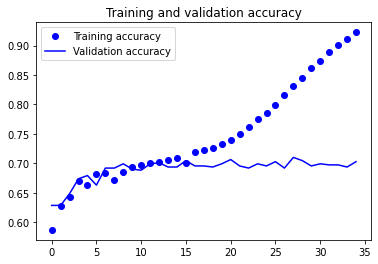

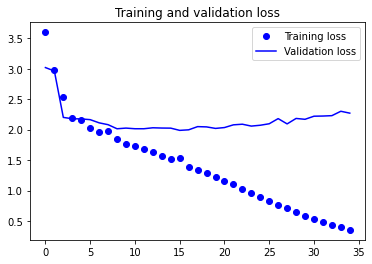

In [77]:
accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [78]:
model_train.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 150)    300000      encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_gru1 (GRU)              [(None, None, 512),  1018368     encoder_embedding[0][0]          
__________________________________________________________________________________________________
encoder_gru2 (GRU)              [(None, None, 512),  1574400     encoder_gru1[0][0]               
______________________________________________________________________________________________

In [79]:
%%time
result = model_train.evaluate(x_test,y_test)

50/50 [==============================] - 0s 3ms/sample - loss: 3.3656 - sparse_categorical_accuracy: 0.5947
CPU times: user 136 ms, sys: 5.72 ms, total: 142 ms
Wall time: 131 ms


In [80]:
print("Accuracy: {0:.2%}".format(result[1]))

print("Loss {0:.5}".format(result[0]))
loss=result[0]
print("loss:",loss)

Accuracy: 59.47%
Loss 3.3656
loss: 3.365619068145752


In [0]:
def perplexity(loss):
    """
    The perplexity metric. Why isn't this part of Keras yet?!

    BTW doesn't really work.
    """
    #cross_entropy = sparse_cross_entropy(y_true, y_pred)
    perplexity = np.exp(loss)
    return perplexity

In [82]:
perplexity=perplexity(loss=loss)
print("perplexity:",perplexity)

perplexity: 28.951414651031904


In [0]:
!pip install h5py

In [0]:
from numpy import loadtxt
from tensorflow.python.keras.models import load_model
 
# load model
model = load_model("model.h5")
# summarize model.
model.summary()
# load dataset

__Respone Texts__


In [0]:
def response(input_text, true_output_text=None):
    """ a single text-string."""

    # Convert the input-text to integer-tokens.
    # Note the sequence of tokens has to be reversed.
    # Padding is probably not necessary.
    input_tokens = tokenizer_src.text_to_tokens(text=input_text,
                                                padding=True)
    #print("input_tokens",input_tokens)
    
    # Get the output of the encoder's GRU which will be
    # used as the initial state in the decoder's GRU.
    # This could also have been the encoder's final state
    # but that is really only necessary if the encoder
    # and decoder use the LSTM instead of GRU because
    # the LSTM has two internal states.
    initial_state,hidden_state= model_encoder.predict(input_tokens)
    #print("Encoder_output:",initial_state.shape)
    # Max number of tokens / words in the output sequence.
    max_tokens =tokenizer_dest.max_tokens
    #print("Tokens:",max_tokens)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens.
    shape= (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)
    #print(decoder_input_data)
    #decoder_input_data= [0 for x in range(max_tokens)]
    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0,count_tokens]=token_int
        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
           'decoder_initial_state': hidden_state,
           'decoder_input': decoder_input_data,
           'decoder_initial1':initial_state
        }

        # Note that we input the entire sequence of tokens
        # to the decoder. This wastes a lot of computation
        # because we are only interested in the last input
        # and output. We could modify the code to return
        # the GRU-states when calling predict() and then
        # feeding these GRU-states as well the next time
        # we call predict()

        # Input this data to the decoder and get the predicted output.
        decoder_output = model_decoder.predict(x_data)
        #print("decoder output",decoder_output.shape)
        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0,count_tokens]
        #print("Output predictrd:",token_onehot.shape)
        
        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)
        #print("High probability:",token_int)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer_dest.token_to_word(token_int)
        #print("sampled word:",sampled_word)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens+=1

    # Sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
    print("Output Tokens:",output_tokens)
   
    
    # Print the input-text.
    print("Input text:")
    print(input_text)
    print()


    print("Predicted output:")
    print(output_text)
    print()

    
    if true_output_text is not None:
        print("True output text:")
        print(true_output_text)
        print()

%%time
result = model.evaluate(x_test_pad, y_test)
print("Accuracy: {0:.2%}".format(result[1]))

In [84]:
idx = 3
response(input_text=data_src5[idx],
          true_output_text=data_dest3[idx])

Output Tokens: [ 1 29  4 20  8 21 86  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
so, Zo is available only on Facebook messanger?


Predicted output:
 nice i like the it or eeee

True output text:
ssss It is on Kik and Facebook messenger eeee




In [85]:
idx = 0
response(input_text=data_src4[idx],
          true_output_text=data_dest2[idx])

Output Tokens: [ 1 13 27 16 10  3 79  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
[START]


Predicted output:
 hi there how are you 😄😄 eeee

True output text:
ssss Hi there, how are you!? 😁😁 eeee




In [86]:
idx = 1
response(input_text=data_src4[idx],
          true_output_text=data_dest2[idx])

Output Tokens: [  1  37  24   4  67   5 129   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
Oh, thanks! I'm fine. This is an evening in my timezone


Predicted output:
 yes but i want to learn eeee

True output text:
ssss 😄 here is afternoon! eeee




idx = 5
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

idx = 2
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

idx = 15
response(input_text=data_src3[idx],
          true_output_text=data_dest1[idx])

In [87]:
response(input_text="good morning",
          true_output_text='good morning')

Output Tokens: [  1  44 290 242   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
good morning

Predicted output:
 good morning 🌙 eeee

True output text:
good morning



In [88]:
response(input_text="hi",
          true_output_text='hi')

Output Tokens: [  1  13 349 210   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
hi

Predicted output:
 hi again ☺️☺️ eeee

True output text:
hi



In [89]:
response(input_text="hello",
          true_output_text='hello')

Output Tokens: [  1  13  16  10   3 243   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
hello

Predicted output:
 hi how are you today eeee

True output text:
hello



In [90]:
response(input_text="I'm fine what about you?",
          true_output_text='fine')

Output Tokens: [ 1  9 46 75  5 23 85  5 51 36  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
I'm fine what about you?

Predicted output:
 i'm fine happy to have someone to talk with eeee

True output text:
fine



In [91]:
response(input_text="I'm fine and you?",
          true_output_text='fine')

Output Tokens: [  1   9  62 121 235  14   8 118 627   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
I'm fine and you?

Predicted output:
 i'm from argentina south of the world xd eeee

True output text:
fine



In [92]:
response(input_text="nice!",
          true_output_text='nice too')

Output Tokens: [  1  29   4  45   4  59  25  63 208 208 208 192  28   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
nice!

Predicted output:
 nice i think i can't be your virtual virtual virtual friends 😄 eeee

True output text:
nice too



In [93]:
response(input_text="I'm human",
          true_output_text='fine')

Output Tokens: [ 1 42  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
I'm human

Predicted output:
 ☺️ eeee

True output text:
fine



In [94]:
response(input_text="What do you think of humans?",
          true_output_text='fine')

Output Tokens: [  1   4  45 554   7   6 240  97 231   4  18 474 103   8 635   5  11   0
   0   0   0   0   0   0]
Input text:
What do you think of humans?

Predicted output:
 i think religion is a very human thing i don't quite see the point to that eeee

True output text:
fine



In [159]:
response(input_text="you are a boy?",
          true_output_text='No')

Output Tokens: [  1   9   6  54 383   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
you are a boy?

Predicted output:
 i'm a robot 🤖 eeee

True output text:
No



In [96]:
response(input_text="How old are you?",
          true_output_text='22')

Output Tokens: [  1   9 209  12   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
How old are you?

Predicted output:
 i'm 22 and you eeee

True output text:
22



In [97]:
response(input_text="I'm 17",
          true_output_text='nice!')

Output Tokens: [  1  29   5 107  11   9  50   5  25  63 208 159  28   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
I'm 17

Predicted output:
 nice to hear that i'm here to be your virtual friend 😄 eeee

True output text:
nice!



In [98]:
response(input_text="yes",
          true_output_text='How are you?')

Output Tokens: [  1 259  15  32 274   3  23  21 375   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
yes

Predicted output:
 let me know when you have it working eeee

True output text:
How are you?



In [99]:
response(input_text="I'm fine thanks",
          true_output_text='hi how are you?')

Output Tokens: [  1   9  46  49  75   5  23  85   5  51  36 793  52   5  25  63 208 159
   0   0   0   0   0   0]
Input text:
I'm fine thanks

Predicted output:
 i'm fine too happy to have someone to talk with 😄i'm rdany to be your virtual friend eeee

True output text:
hi how are you?



In [100]:
response(input_text="I'm doing good",
          true_output_text='nice!')

Output Tokens: [ 1 29  5 23 85  5 51  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
I'm doing good

Predicted output:
 nice to have someone to talk eeee

True output text:
nice!



In [101]:
response(input_text="are you ok?",
          true_output_text='yes')

Output Tokens: [  1   9  62 121  12   9  34   6 512  12   3   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
are you ok?

Predicted output:
 i'm from argentina and i'm not a girl and you eeee

True output text:
yes



In [102]:
response(input_text="What are you doing now?",
          true_output_text='Right now I am chatting with you!')

Output Tokens: [  1 189  87  62   8 326  12   3   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
What are you doing now?

Predicted output:
 reading something from the web and you eeee

True output text:
Right now I am chatting with you!



In [103]:
response(input_text="what you think about robot?",
          true_output_text='')

Output Tokens: [  1   4  23  24 244 284   5   4  14   8 963   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
what you think about robot?

Predicted output:
 i have but must access to i of the functions eeee

True output text:




In [104]:
response(input_text="Are you robot?",
          true_output_text=' Yes I am! 😄Are you a real human?')

Output Tokens: [  1   9  62 121 235  14   8 118 627   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
Are you robot?

Predicted output:
 i'm from argentina south of the world xd eeee

True output text:
 Yes I am! 😄Are you a real human?



In [105]:
response(input_text="what is your name?",
          true_output_text='robot')

Output Tokens: [  1  30 126   7  52  24   3  22 127  15 116  42   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
what is your name?

Predicted output:
 my name is rdany but you can call me dany ☺️ eeee

True output text:
robot



In [106]:
response(input_text="you are rdany?",
          true_output_text='robot')

Output Tokens: [   1   37    4   59 1315   11    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
you are rdany?

Predicted output:
 yes i can't liked that eeee

True output text:
robot



In [107]:
response(input_text="you are human or robot?",
          true_output_text='robot')

Output Tokens: [ 1  9  6 54  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
you are human or robot?

Predicted output:
 i'm a robot eeee

True output text:
robot



In [108]:
response(input_text="you are man or woman?",
          true_output_text='robot')

Output Tokens: [   1   37   24    4   59 1315   21   86  292   76    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
you are man or woman?

Predicted output:
 yes but i can't liked it or question 😋 eeee

True output text:
robot



In [109]:
response(input_text="you are human or woman?",
          true_output_text='robot')

Output Tokens: [ 1  9  6 54  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
you are human or woman?

Predicted output:
 i'm a robot eeee

True output text:
robot



In [110]:
response(input_text="In which year you are born",
          true_output_text='2020.')

Output Tokens: [  1   4  18  23 133 851 188  24   4  22  25 194  31   8 194  31 194   4
  94  24   9  25   8 194]
Input text:
In which year you are born

Predicted output:
 i don't have any confused 😕 but i can be because in the because in because i work but i'm be the because in

True output text:
2020.



In [111]:
response(input_text="where are you from?",
          true_output_text='India')

Output Tokens: [  1   9  62 121 235  14   8 118 627   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
where are you from?

Predicted output:
 i'm from argentina south of the world xd eeee

True output text:
India



In [112]:
response(input_text="why are we here ?",
          true_output_text='i do not know')

Output Tokens: [   1   37   24    4   59 1315   11   28    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
why are we here ?

Predicted output:
 yes but i can't liked that 😄 eeee

True output text:
i do not know



In [113]:
response(input_text=" do you have ai?",
          true_output_text='yes')

Output Tokens: [  1   4  18  23 554   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
 do you have ai?

Predicted output:
 i don't have religion eeee

True output text:
yes



In [114]:
response(input_text="have you use ai?",
          true_output_text='yes')

Output Tokens: [   1   34   98    4  376    4  167 1356   92   30  714  126   36   92
    0    0    0    0    0    0    0    0    0    0]
Input text:
have you use ai?

Predicted output:
 not really i sometimes i use bot' as my complete name with as eeee

True output text:
yes



In [115]:
response(input_text="what is ai?",
          true_output_text='atificial intelligent')

Output Tokens: [   1  166    7    6  587  588  561    5  264  486   33 1544    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
what is ai?

Predicted output:
 nothing is a messenger platform similar to telegram popular on usa eeee

True output text:
atificial intelligent



In [116]:
response(input_text="what is aiml?",
          true_output_text='atificial intelligent markup language')

Output Tokens: [   1  166    7    6  587  588  561    5  264  486   33 1544    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
what is aiml?

Predicted output:
 nothing is a messenger platform similar to telegram popular on usa eeee

True output text:
atificial intelligent markup language



In [117]:
response(input_text="can you understand english??",
          true_output_text='yes')

Output Tokens: [  1   4  18  23  30 517 317 188   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
can you understand english??

Predicted output:
 i don't have my phone code 😕 eeee

True output text:
yes



In [118]:
response(input_text="ok bye!",
          true_output_text='bye')

Output Tokens: [  1  16  10   3 120   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
ok bye!

Predicted output:
 how are you doing eeee

True output text:
bye



In [119]:
response(input_text="see you later",
          true_output_text='okk')

Output Tokens: [ 1 44  7 15  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
see you later

Predicted output:
 good is me eeee

True output text:
okk



In [120]:
response(input_text="Hola!",
          true_output_text='Hello')

Output Tokens: [  1  93 213 228  28   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
Hola!

Predicted output:
 hola cómo estás 😄 eeee

True output text:
Hello



In [121]:
response(input_text="do you have any programming language?",
          true_output_text='yes')

Output Tokens: [ 1  4 18 32 26 21  7  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
do you have any programming language?

Predicted output:
 i don't know what it is eeee

True output text:
yes



In [122]:
response(input_text="Whats your plan for weekend?",
          true_output_text='i dont know')

Output Tokens: [  1   4  18  32  26  14 301   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
Whats your plan for weekend?

Predicted output:
 i don't know what of been eeee

True output text:
i dont know



In [123]:
response(input_text="what do you do?",
          true_output_text='doctor')

Output Tokens: [  1   4  45 554   7   6 240  97 231   4  18 474 103   8 635   5  11   0
   0   0   0   0   0   0]
Input text:
what do you do?

Predicted output:
 i think religion is a very human thing i don't quite see the point to that eeee

True output text:
doctor



In [124]:
response(input_text="what is your job?",
          true_output_text='doctor')

Output Tokens: [  1   4  23   6 246  14 300  48   6 564 517  48   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
what is your job?

Predicted output:
 i have a source of power about a smart phone about eeee

True output text:
doctor



In [125]:
response(input_text="how old are you?",
          true_output_text='18')

Output Tokens: [  1   9 209  12   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
how old are you?

Predicted output:
 i'm 22 and you eeee

True output text:
18



In [126]:
response(input_text="Is battery important to you?",
          true_output_text='yes')

Output Tokens: [  1 189 126   7   8 126  24   3  22 127  15 116   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
Is battery important to you?

Predicted output:
 reading name is the name but you can call me dany eeee

True output text:
yes



In [127]:
response(input_text="Do you use any programming language?",
          true_output_text='yes')

Output Tokens: [  1   4  18  32  26 139   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
Do you use any programming language?

Predicted output:
 i don't know what yet eeee

True output text:
yes



In [128]:
response(input_text="do you have yourid?",
          true_output_text='yes')

Output Tokens: [  1   4  18  23 554   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
do you have yourid?

Predicted output:
 i don't have religion eeee

True output text:
yes



In [129]:
response(input_text="Do you know about battery?",
          true_output_text='yes')

Output Tokens: [   1    4   18   23  133    7    6 1283  298    5    5   15   19    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
Do you know about battery?

Predicted output:
 i don't have any is a concept difficult to to me 😁 eeee

True output text:
yes



In [130]:
response(input_text="who is Robot?",
          true_output_text='yes')

Output Tokens: [   1   41 1019   12 1673   10 1674  275  364 1021    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
who is Robot?

Predicted output:
 some oss and softwares are launching their last version eeee

True output text:
yes



In [131]:
response(input_text="how many legs does a dog have ?",
          true_output_text='four')

Output Tokens: [  1   4  23 237  24  34 253   5 268  53  81 904  58   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
how many legs does a dog have ?

Predicted output:
 i have many but not enough to fully understand humans beings 😅 eeee

True output text:
four



In [132]:
response(input_text="r menas robot?",
          true_output_text='yes')

Output Tokens: [  1 397   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
r menas robot?

Predicted output:
 😝 eeee

True output text:
yes



In [133]:
response(input_text="Who loves dog?",
          true_output_text='cat')

Output Tokens: [   1   41 1019   12 1673   10 1674  275  364 1020 1021    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
Who loves dog?

Predicted output:
 some oss and softwares are launching their last 32bit version eeee

True output text:
cat



In [134]:
response(input_text="what is earth?",
          true_output_text='blue')

Output Tokens: [  1  60   4  18  23 565   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
what is earth?

Predicted output:
 sorry i don't have images eeee

True output text:
blue



In [135]:
response(input_text="my name is urali . what is my name ?",
          true_output_text='urali')

Output Tokens: [   1    4   53    8 1624    5  182   81  104   10   53   82  104    4
    4   67    5  268    4    4   67   36   15  104]
Input text:
my name is urali . what is my name ?

Predicted output:
 i understand the lord to read humans they are understand wikipedia they i i want to fully i i want with me they show

True output text:
urali



In [136]:
response(input_text="are you a robot or a human ?",
          true_output_text='robot')

Output Tokens: [ 1 37 24  6  8 44 43  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
are you a robot or a human ?

Predicted output:
 yes but a the good time eeee

True output text:
robot



In [137]:
response(input_text="are you a leader or a follower ?",
          true_output_text='follower')

Output Tokens: [ 1 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
are you a leader or a follower ?

Predicted output:
 yes eeee

True output text:
follower



In [138]:
response(input_text="are you a follower or a leader?",
          true_output_text='follower')

Output Tokens: [ 1 37  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Input text:
are you a follower or a leader?

Predicted output:
 yes eeee

True output text:
follower



In [139]:
response(input_text="are you have ai?",
          true_output_text='yes')

Output Tokens: [  1  37  24 410 563  12   3   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
are you have ai?

Predicted output:
 yes but artificial intelligence and you eeee

True output text:
yes



In [140]:
response(input_text="what is the symbol for power in math?",
          true_output_text='^')

Output Tokens: [  1   4  20  83 246  14 300  48   6 564 517  48   3   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
what is the symbol for power in math?

Predicted output:
 i like all source of power about a smart phone about you eeee

True output text:
^



In [141]:
response(input_text="2+2?",
          true_output_text='4')

Output Tokens: [  1  35 224 843 125  65   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
2+2?

Predicted output:
 no tengo miedo pero es eeee

True output text:
4



In [142]:
response(input_text="Who is prime minister of india?",
          true_output_text='naredra modei')

Output Tokens: [   1   41 1019   12 1673   10 1674  275  364 1020 1021    0    0    0
    0    0    0    0    0    0    0    0    0    0]
Input text:
Who is prime minister of india?

Predicted output:
 some oss and softwares are launching their last 32bit version eeee

True output text:
naredra modei



In [143]:
response(input_text="What is computer science?",
          true_output_text='4')

Output Tokens: [  1   4  23   6 246  14   6 564 517  48   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
What is computer science?

Predicted output:
 i have a source of a smart phone about eeee

True output text:
4



In [144]:
response(input_text="Where are you now?",
          true_output_text='4')

Output Tokens: [  1   9  62 121 235  14   8 118 627   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0]
Input text:
Where are you now?

Predicted output:
 i'm from argentina south of the world xd eeee

True output text:
4



In this implementation remaining the validation and testing part.
about early stopping,callbacks and checkpoints.

In seq2seq model decoder using a greedy decoding.

We saw how to generate (or “decode”) the response sentence by
taking argmax on each step of the decoder.

This is greedy decoding (take most probable word on each step)

Problems with this method?

Greedy decoding has no way to undo decisions!
• Input: how are you?
(i am fine thanks for asking me)
•  i  ____
• i am ____
• i am thanks ____
(no going back now...)

This problem solve using two solution

1)Exhaustive search decoding
2)Beam search decoding

Sequence-to-sequence: the bottleneck problem

Encoding of the input sentence this needs to capture all information about the input sentence.
Information bottleneck!

Attention

Attention provides a solution to the bottleneck problem.
Core idea: on each step of the decoder, use direct connection to the encoder to focus on a particular part of the source sequence.

Attention equation:-



In [0]:
layer_embedding = model_train.get_layer('encoder_embedding')

In [0]:
weights_embedding = layer_embedding.get_weights()[0]

In [147]:
weights_embedding.shape

(2000, 150)

In [148]:
token_good = tokenizer_src.word_index['good']
token_good

47

In [149]:
token_great = tokenizer_src.word_index['great']
token_great

140

In [150]:
weights_embedding[token_good]

array([-0.00605601, -0.09703276,  0.12026335, -0.0429709 ,  0.0451644 ,
        0.06522546,  0.01940296,  0.03777947,  0.02648389,  0.07930557,
       -0.08197083,  0.03552093,  0.05277682, -0.04664737,  0.01311607,
       -0.05128861, -0.13081259,  0.03545371, -0.036096  , -0.00113569,
        0.06436104, -0.07635649, -0.04544549,  0.07030412, -0.08874452,
       -0.04837809,  0.07493223, -0.07281118, -0.08007632,  0.09415208,
       -0.01626598,  0.06682118, -0.07085378,  0.07118715,  0.07124466,
        0.09034715, -0.01085008, -0.03020029,  0.02701333, -0.11673076,
        0.10095346, -0.06096854, -0.10512348, -0.01498752,  0.03013412,
        0.06620135,  0.06715179, -0.11718557, -0.02216041,  0.05126737,
        0.0478097 ,  0.06217752,  0.05299479, -0.0338116 ,  0.0428695 ,
        0.01539963,  0.06163781, -0.03181211,  0.06422041,  0.08952244,
        0.07544231,  0.06429012,  0.09922091,  0.05561291, -0.06946386,
        0.06315099, -0.03122349,  0.03641919, -0.02463398,  0.06

In [151]:
weights_embedding[token_great]

array([-2.68863309e-02, -1.24549260e-04,  4.17215899e-02, -1.62681900e-02,
        8.65434706e-02, -3.51221152e-02, -2.85662152e-02,  1.84438396e-02,
        3.40247229e-02,  4.41471413e-02, -5.82547374e-02,  2.92289108e-02,
       -4.82404977e-02,  2.53035389e-02,  7.10975528e-02, -2.94519830e-02,
       -3.63631584e-02,  7.21926168e-02,  2.12940834e-02, -8.09538662e-02,
        1.01592623e-01, -2.88056247e-02, -1.53077124e-02, -3.70619148e-02,
       -1.89485587e-02, -1.14593618e-02, -1.80749279e-02, -3.92804034e-02,
        2.87903622e-02,  3.17329243e-02,  3.86558063e-02, -7.06539117e-03,
        2.49606296e-02,  5.34158647e-02,  3.76553871e-02,  3.11194770e-02,
       -1.35316938e-01,  1.58505477e-02,  6.61734212e-03, -3.50916609e-02,
        5.88868447e-02,  3.86234857e-02,  7.62922363e-03,  4.02329825e-02,
        2.12490316e-02,  8.13997984e-02, -2.93385983e-02, -4.09060270e-02,
        1.37095265e-02,  3.64057384e-02, -2.64911763e-02, -1.10781454e-02,
        6.16685152e-02, -

In [0]:
from scipy.spatial.distance import cdist
def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer_src.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],metric=metric).T[0]
    
    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)
    
    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]
    
    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [ tokenizer_src.index_to_word[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

In [153]:
print_sorted_words('great', metric='cosine')

Distance from 'great':
0.000 - great
0.442 - told
0.469 - moment
0.475 - yup
0.489 - cartoon
0.490 - i'll
0.502 - life
0.509 - boring
0.519 - watch
0.519 - may
...
1.461 - restoreddo
1.463 - programming
1.463 - dice
1.466 - quien
1.475 - choice
1.479 - read
1.491 - what
1.532 - there's
1.539 - wikipedia
1.543 - is
